# Team 11: Predicting the Impact of Twitter Posts on Bitcoin Prices

**Group Members:**  Andrey Bartashevich (14586517), Finn Prins (13458434), Duco Trompert (14591227)

**Research Question:** Can Twitter (a.k.a. X) posts of famous people influence the prices of Bitcoin?

# Hypothesis: 
**Null hypothesis:** There is no impact of Twitter  posts by individuals with over one million followers on the Bitcoin price movements.

**Alternative Hypothesis:** There is an impact of Twitter posts by individuals with over one million followers on the Bitcoin price movements


**Potentialy change the 1 mill foloowers with 250 000 followers, because the dataset doesnt have enough values for users with 1 000 000 followers.**

**Imports**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from langdetect import detect
from langdetect import DetectorFactory
import pandas as pd

**Data Processing**

Twitter dataset

In [2]:
#open twitter csv file
tweet = pd.read_csv('data/tweets.csv', delimiter=';', lineterminator='\n')
tweet = tweet.head(500)
#rename timestamp and text\r columns 
tweet.rename(columns={'timestamp' : 'date','text\r' : 'text'}, inplace=True)
#convert data to datetime format, and drop timezone information as it is irrelevant
tweet['date'] = pd.to_datetime(tweet['date']).dt.tz_localize(None)
#rounding seconds in date for consistency with bitcoin dataset
tweet['date'] = tweet['date'].dt.round('T')
#specified columns
tweet[['date', 'user', 'fullname', 'replies', 'likes', 'retweets', 'text']]
print(len(tweet))

/var/folders/d6/qmvkgm9x2kq_2htc9f1yhtb00000gn/T/ipykernel_1366/3492338420.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  tweet = pd.read_csv('data/tweets.csv', delimiter=';', lineterminator='\n')


500


Bitcoin dataset

In [3]:
#open bitcoin csv
bitcoin = pd.read_csv('data/btcusd_1-min_data.csv')
#renaming timestamp, Close and Volume columns 
bitcoin.rename(columns={'Timestamp' : 'date','Close': 'price', 'Volume' : 'volume'}, inplace=True)
#converting date into datetime
bitcoin['date'] = pd.to_datetime(bitcoin['date'], unit='s')
#specified columns
bitcoin[['date','price','volume']].head()


,date,price,volume
0,2012-01-01 10:01:00,4.58,0.0
1,2012-01-01 10:02:00,4.58,0.0
2,2012-01-01 10:03:00,4.58,0.0
3,2012-01-01 10:04:00,4.58,0.0
4,2012-01-01 10:05:00,4.58,0.0


Merging two datasets

In [4]:
#mergin two datasets by date
merged = pd.merge(tweet[['date', 'user', 'fullname', 'replies', 'likes', 'retweets', 'text']],
                  bitcoin[['date', 'price', 'volume']], on='date', how='inner')
merged.head()
print(len(merged))


499


Data visualization

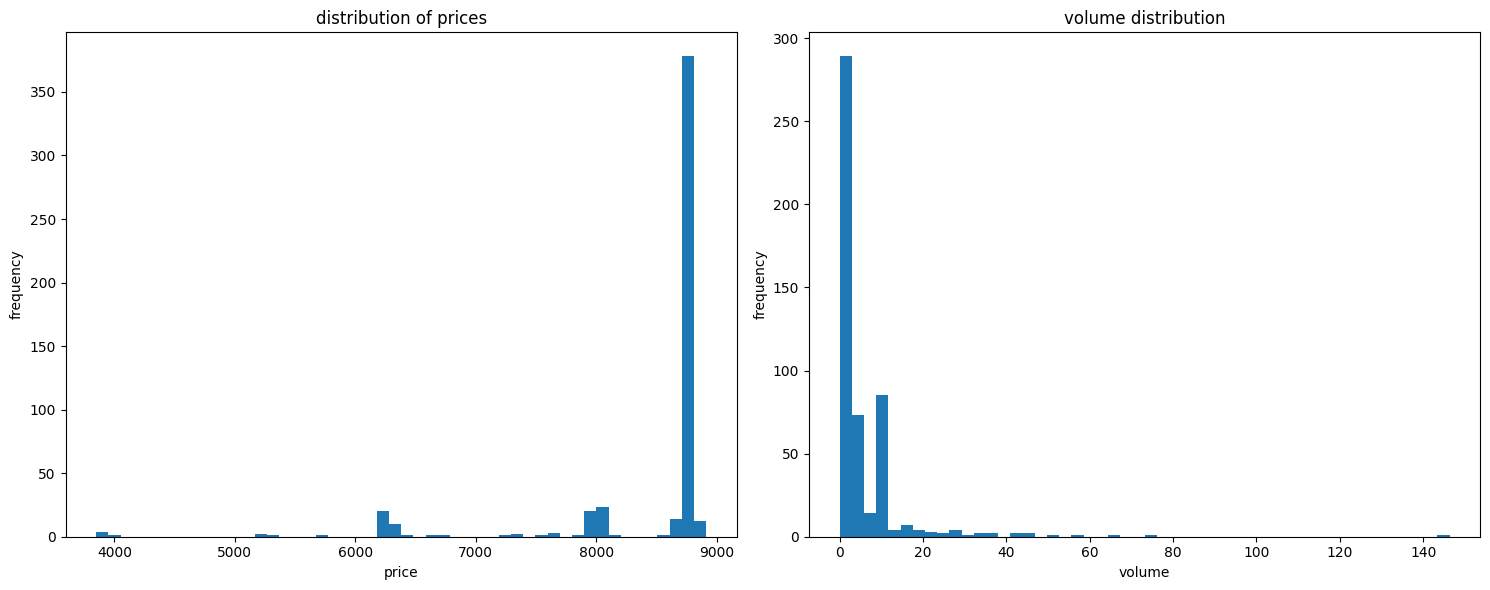

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.hist(merged['price'], bins=50)
ax1.set_title('distribution of prices')
ax1.set_xlabel('price')
ax1.set_ylabel('frequency')
ax2.hist(merged['volume'], bins=50)
ax2.set_title('volume distribution')
ax2.set_xlabel('volume')
ax2.set_ylabel('frequency')
plt.tight_layout()
plt.show()

In [ ]:
# set seed for consistency of results
DetectorFactory.seed = 0


#detection of english tweets amoung tweets
def is_english(text):
        #check if the line is Nan or empty
        if pd.isna(text) or text.strip() == '':
            return False
        #using detect function to find english text
        return detect(text) == 'en'


#sentiment analysis using vader library 
def vader_sentiment(text):
        #starting vader module for text analysis
        analyzer = SentimentIntensityAnalyzer()
        #geting sentiment scores on a scale from -1 to 1 as a dictionary (compound)
        scores = analyzer.polarity_scores(text)
        # calcualting the sentiment of each text based on the compund score
        #positive
        if scores['compound'] >= 0.05:
            sentiment = 1
        #negative 
        elif scores['compound'] <= -0.05:
            sentiment = -1
        #neutral 
        else:
            sentiment = 0

        return {'sentiment':sentiment, 'compound':scores['compound'], 'text':text}


#replacing nan with empty line
merged['text'] = merged['text'].fillna('')
#convert all values into str
merged['text'] = merged['text'].astype(str)
#only taking english text and coping
en_merged = merged[merged['language'] == 'en'].copy()


results = en_merged['text'].apply(vader_sentiment)

#creating a series with sentiment, compund, text
en_merged['sentiment'] = results.apply(lambda x: x['sentiment'])
en_merged['compound'] = results.apply(lambda x: x['compound'])
en_merged['analyzed_text'] = results.apply(lambda x: x['text'])
en_merged_res = en_merged[['sentiment', 'compound', 'analyzed_text']]

print(en_merged_res .head())

   sentiment  compound                                      analyzed_text
1          1    0.3818  Cardano: Digitize Currencies; EOS https://t.co...
2          0    0.0000  Another Test tweet that wasn't caught in the s...
3          0    0.0000  Current Crypto Prices! \n\nBTC: $8721.99 USD\n...
4          1    0.3612  Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...
6         -1   -0.4767  @nwoodfine We have been building on the real #...


In [36]:
pos_count, neu_count, neg_count = 0, 0, 0

for i_sent in en_merged_res['sentiment']:
    if i_sent == 1:
        pos_count += 1
    elif i_sent == 0:
        neu_count += 1
    else:
        neg_count += 1

print(f'positive: {pos_count}')
print(f'neutral: {neu_count}')
print(f'negative: {neg_count}')

positive: 173
neutral: 128
negative: 44
